# Serial Nbody Simulations

In [1]:
import os
from os import path 
from time import time

import numpy as np 

from astropy import units as u 
from astropy import constants as const 

In [2]:
%matplotlib inline 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.rcParams['figure.figsize'] = [6, 6]
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['font.size'] = 12

In [3]:
import peytonites
from peytonites import (
    Distribution, SimState,
    kpc_to_cm, cm_to_kpc, 
    lyr_to_cm, cm_to_lyr, 
    au_to_cm, cm_to_au
)

## Inital Conditions

### Load Inital Condition

In [4]:
sim_init_cond = SimState.read('data/solar_system_10000step_init.dat')

## Traditional Simulation

In [5]:
def traditional_simulation(sim_init_cond, out_dir, verbose=True):
    
    G = sim_init_cond.G # cm^3 / (g s^2)
    dt = sim_init_cond.dt
    nsteps = sim_init_cond.nsteps
    out_interval = sim_init_cond.out_interval
    soft = sim_init_cond.soft
    
    init_dist = sim_init_cond.distribution
    
    number_particles = init_dist.N
    
    x_arr = init_dist.x.copy()
    y_arr = init_dist.y.copy()
    z_arr = init_dist.z.copy()
    
    vx_arr = init_dist.vx.copy()
    vy_arr = init_dist.vy.copy()
    vz_arr = init_dist.vz.copy()
    
    mass_arr = init_dist.m.copy()
    #----------------------------------------
    for step in range(nsteps): 
        ax_arr = np.zeros_like(x_arr)
        ay_arr = np.zeros_like(x_arr)
        az_arr = np.zeros_like(x_arr)

        for i in range(number_particles):
            ax, ay, az = 0., 0., 0.
            xi, yi, zi = x_arr[i], y_arr[i], z_arr[i]

            for j in range(number_particles):
                if i == j:
                    continue

                dx = xi - x_arr[j]
                dy = yi - y_arr[j]
                dz = zi - z_arr[j]

                r_ij_squared = dx**2 + dy**2 + dz**2 + soft**2
                r_ij = np.sqrt(r_ij_squared)
                r_ij_cubed = r_ij_squared * r_ij

                mj = mass_arr[j]
                a = - (G * mj) / r_ij_cubed

                ax += a * dx 
                ay += a * dy 
                az += a * dz 

            ax_arr[i] = ax 
            ay_arr[i] = ay
            az_arr[i] = az

        
        for i in range(number_particles):

            vx_arr[i] += ax_arr[i] * dt
            vy_arr[i] += ay_arr[i] * dt
            vz_arr[i] += az_arr[i] * dt


            x_arr[i] += vx_arr[i] * dt
            y_arr[i] += vy_arr[i] * dt
            z_arr[i] += vz_arr[i] * dt
    #----------------------------------------

        if step % out_interval == 0:
            if verbose:
                print(step)
            
            step_params = sim_init_cond.copy()
            if step > 0:
                step_dist = Distribution.from_arrays(
                    x_arr, y_arr, z_arr, 
                    vx_arr, vy_arr, vz_arr,
                    mass_arr, name=init_dist.name)

                step_params = sim_init_cond.copy()
                step_params.distribution = step_dist                
            
            step_filename = 'step_{:08d}.dat'.format(step)
            step_path = path.join(out_dir, step_filename)
            
            if not os.path.isdir(out_dir):
                os.makedirs(out_dir)
            
            step_params.write(step_path)
            
    if verbose:
        print(step)
    return 
    

### Define Output Dir

Make sure to have a `simout` in the name for git ignore

In [6]:
out_dir = './solar_system_simout'

In [7]:
tstart = time()
traditional_simulation(sim_init_cond, out_dir, verbose=False)
tend = time()

traditional_run_time = (tend-tstart)*u.s
print('done', 'traditional_run_time:', traditional_run_time)

done traditional_run_time: 2.7658839225769043 s


## Vector Simulation

**Running this will replace/overwrite the last outputs**

Using vectorized operations in this implementation significantly reduces computation time compared to the double for-loop, but at the cost of massively increased memory usage due to storing large intermediate arrays for pairwise distances and accelerations.



In [8]:
def vector_simulation(sim_init_cond, out_dir, verbose=True):
    
    G = sim_init_cond.G # cm^3 / (g s^2)
    dt = sim_init_cond.dt
    nsteps = sim_init_cond.nsteps
    out_interval = sim_init_cond.out_interval
    soft = sim_init_cond.soft
    
    init_dist = sim_init_cond.distribution
    
    number_particles = init_dist.N
    
    x_arr = init_dist.x.copy()
    y_arr = init_dist.y.copy()
    z_arr = init_dist.z.copy()
    
    vx_arr = init_dist.vx.copy()
    vy_arr = init_dist.vy.copy()
    vz_arr = init_dist.vz.copy()
    
    mass_arr = init_dist.m.copy()
    #----------------------------------------
    for step in range(nsteps): 
        dx = x_arr[:, np.newaxis] - x_arr
        dy = y_arr[:, np.newaxis] - y_arr
        dz = z_arr[:, np.newaxis] - z_arr
        
        # Avoid division by zero by adding softening length
        r_squared = dx**2 + dy**2 + dz**2 + soft**2
        np.fill_diagonal(r_squared, 1)  # Avoid self-interaction
        
        r = np.sqrt(r_squared)
        r_cubed = r_squared * r
        
        # Compute accelerations
        a = -G * mass_arr / r_cubed
        np.fill_diagonal(a, 0)  
        ax_arr = np.sum(a * dx, axis=1)
        ay_arr = np.sum(a * dy, axis=1)
        az_arr = np.sum(a * dz, axis=1)
        
        
        # Update velocities and positions
        vx_arr += ax_arr * dt
        vy_arr += ay_arr * dt
        vz_arr += az_arr * dt
        
        x_arr += vx_arr * dt
        y_arr += vy_arr * dt
        z_arr += vz_arr * dt
    #----------------------------------------

        if step % out_interval == 0:
            if verbose:
                print(step)
            
            step_params = sim_init_cond.copy()
            if step > 0:
                step_dist = Distribution.from_arrays(
                    x_arr, y_arr, z_arr, 
                    vx_arr, vy_arr, vz_arr,
                    mass_arr, name=init_dist.name)

                step_params = sim_init_cond.copy()
                step_params.distribution = step_dist                
            
            step_filename = 'step_{:08d}.dat'.format(step)
            step_path = path.join(out_dir, step_filename)
            
            if not os.path.isdir(out_dir):
                os.makedirs(out_dir)
            
            step_params.write(step_path)
            
    #----------------------------------------
    if verbose:
        print(step)
    return 
    

In [9]:
tstart = time()
vector_simulation(sim_init_cond, out_dir, verbose=False)
tend = time()

vector_run_time = (tend-tstart)*u.s
print('done', 'vector_run_time', vector_run_time)

done vector_run_time 0.6875908374786377 s


## Visualization

### By "Hand"

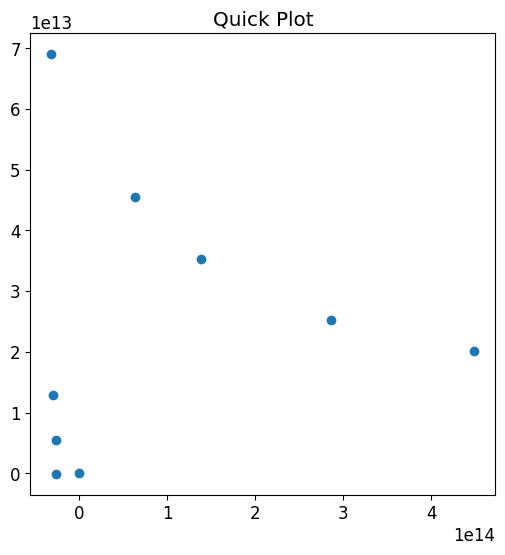

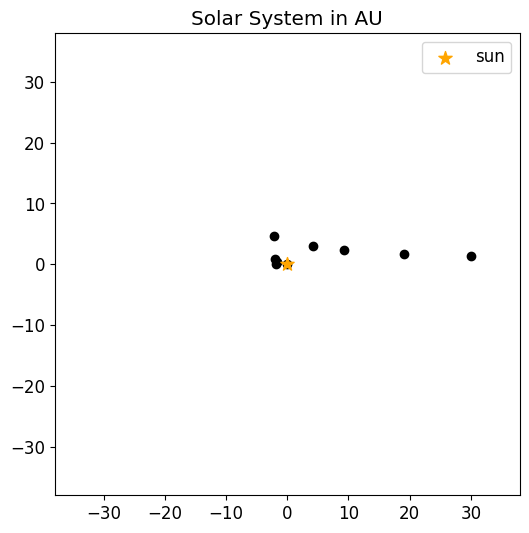

In [10]:
file_path = path.join(out_dir, 'step_00001500.dat')

# Load simulation state
step_state = SimState.read(file_path)

# Get particle distribution 
dist = step_state.distribution

# Plot x and y in cm 
plt.scatter(dist.x, dist.y)
plt.title('Quick Plot')
plt.show()

# Plot x and y in AU 
# (you can also use astropy units) 
plt.scatter(cm_to_au(dist.x), cm_to_au(dist.y), c='k')

# Make the sun a star
plt.scatter(cm_to_au(dist.x[0]), cm_to_au(dist.y[0]), 
            marker='*', c='orange', s=100, label='sun')

plt.xlim(-38, 38)
plt.ylim(-38, 38)
plt.title('Solar System in AU')
plt.legend()

plt.show()

### 2D GIF

This gif will be saved in the `out_dir`. Its kind of slow but does the job! 

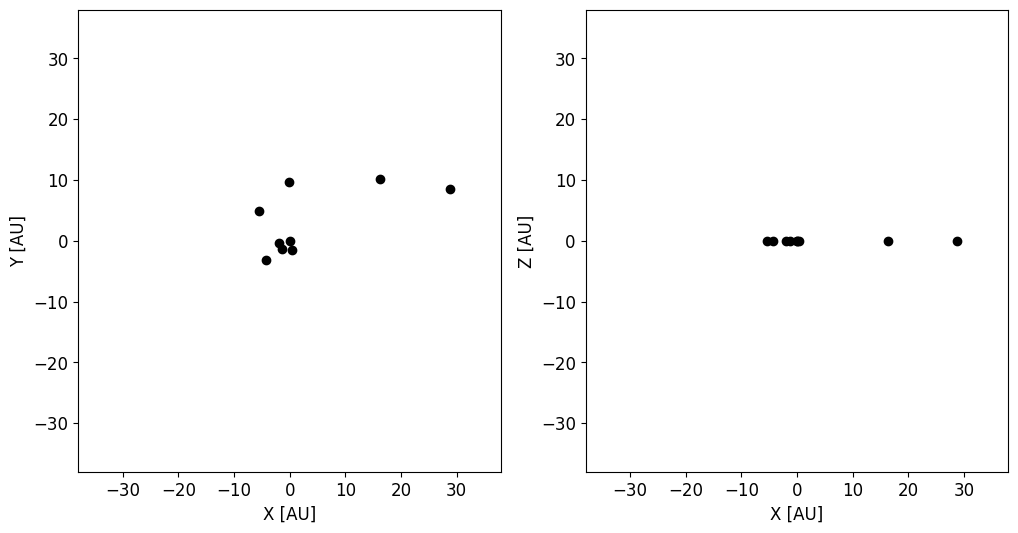

In [11]:
peytonites.simulation_to_gif_2d(
    out_dir, 
    gif_filename='solar_sys_2d.gif', 
    extent=38*u.AU, 
    unit='AU'
)

![im1](solar_system_simout/solar_sys_2d.gif)

### 3D GIF

This gif will be saved in the `out_dir`. Its kind of slow but does the job! 

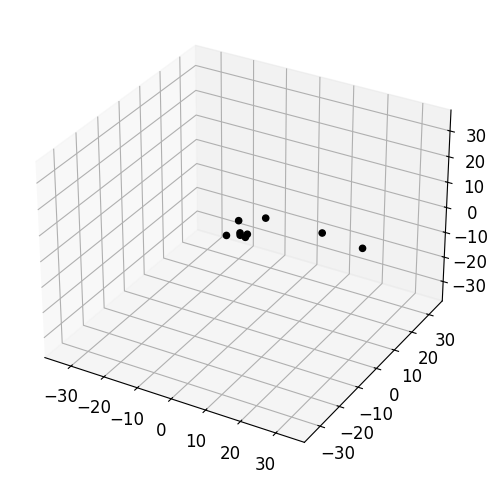

In [12]:
peytonites.simulation_to_gif_3d(out_dir, gif_filename='solar_sys_3d.gif', extent=38*u.AU, unit='AU')

![im2](solar_system_simout/solar_sys_3d.gif)